In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob

from scipy.signal import find_peaks


from IPython import display

**Summary**

This notebook generate matrix with features for matricies with Fourier spectrum for electrode and optical mapping. 

Features description:

-  *freq i* - frequency of i$^{th}$ heightest peak
-  *height i* - height of i$^{th}$ heightest peak
-  *width i* - width of i$^{th}$ heightest peak
-  *prominence i* - prominence of i$^{th}$ heightest peak
-  *#peaks_th* - number of peaks for given (th) threshhold
-  *low_freq_noise* - presence of low-frequency noise (frequency of one of the n highest peaks in the interval from 0 to lf_thHz)


### Upload data

In [47]:
path = r'C:\Users\Public\Documents\HRS\27.11'

In [106]:
# el_sig = pd.read_csv(path + '\All FFT of EL no noise with hpf no zero del no 72_F75.csv', index_col=0)
om_sig = pd.read_csv(path + '\All FFT of OM no noise with hpf no zero del no 72_F75.csv', index_col=0)

In [107]:
om_sig.fillna(value=0, axis=1, inplace=True)

Text(0.5,1,'FFT of all drivers')

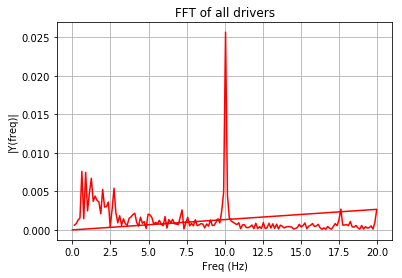

In [55]:
plt.plot(el_sig.iloc[:,-3], el_sig.iloc[:,-4], color='r')
# plt.xlim(0,20)
#plt.ylim(0, 0.15)
plt.grid(True)
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.title('FFT of all drivers')

In [45]:
# el_sig.iloc[:,-3:-1]

In [46]:
# el_sig

### Feature generation

In [108]:
"""
Function that generates pd.DataFrame with amount of peaks for (th*100)% threshhold. 

Parameters: 

full_df: Dataframe
Dataframe with fourier spectrum

th: float, from 0 to 1
threshhold

Returns: 

features: DataFrame, shape=(full_df[1]/2, 1)
number of peaks
"""

def number_of_peaks(full_df, th):
    all_props = []
    df = full_df[full_df.columns[::2]][:-1]
    for col in df:
        _, properties = find_peaks(df[col], height=0)
        all_props.append(properties)
    
    num_of_peaks = []
    
    for i in range(len(all_props)):
        try:
            max_height = np.max(all_props[i]['peak_heights'])
            peaks, _ = find_peaks(df.iloc[:,i], threshold=th*max_height)
            num = peaks.shape[0]
        except ValueError:
            num = 0
        num_of_peaks.append(num)
    num_of_peaks = pd.DataFrame(num_of_peaks, columns=['#peaks_' + str(th)])
    return(num_of_peaks)

In [72]:
number_of_peaks(om_sig, 0.1).head(50)

,#peaks_0.1
0,8
1,32
2,18
3,23
4,0
5,0
6,0
7,0
8,0
9,1


In [109]:
"""
Function that generates pd.DataFrame with different properties for n highest peaks. Properties - values of frequency, 
height, width of the peak for half peak height, prominence and existence of second harmonics. 

In more details about properties https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

Parameters: 

full_df: Dataframe
Dataframe with fourier spectrum

n: int
number of peaks

lf_th: float
threshold for low frequency noise (1Hz by default)

Returns: 

features: DataFrame, shape=(full_df.shape[1]/2, n*4)
properties of n hightest peaks
"""

def properties_of_peaks(full_df, n, lf_th=1):
    
    all_peaks = []
    all_props = []
    df = full_df[full_df.columns[::2]][:-1]
    xf = full_df[full_df.columns[1::2]][:-1]
    
    for col in df:
        
        peaks, properties = find_peaks(df[col], height=0, width=0, prominence=0, rel_height=0.5)
        properties['peak_index'] = peaks
        all_props.append(properties)
        all_peaks.append(peaks)
        
    
    index = []
    freq = []
    height = []
    width = []
    prominence = []
    low_noise = []
    freq_forharm =[] # list for second harmonics detection (binary classification)
    
    features = pd.DataFrame()
    
    for i in range(len(all_props)):
        try:
            z = np.argsort(all_props[i]['peak_heights'])
            z = z[:-(n+1):-1]
            idx = all_props[i]['peak_index'][z] #index of max peaks

            fr_forharm = xf.iloc[:,i][all_peaks[i][z]] # list of frequencies for max peaks
            index_forharm = 0 #initiation of second harmonics index (for each i) 
            for q in range(n):
                for p in range(n):
                    try:
                        a=fr_forharm[p]/fr_forharm[q] #frequencies relation
            #                 print(i,a)
                        if (a<2.1) and (a>1.9): index_forharm = 1 # if relation is 2 plus/minus 5% output 1 
                    except ZeroDivisionError:
                        a=0 
            freq_forharm.append(index_forharm)
            
            for j in range(n):
                fr = xf.iloc[:,i][all_peaks[i][z][j]] #freqs of max peaks
                freq.append(fr)
            
            h = all_props[i]['peak_heights'][z] #heights of max peaks
            height.append(h)
            w = all_props[i]['widths'][z] #width of max peaks
            width.append(w)
            p = all_props[i]['prominences'][z]
            prominence.append(p)

            low_freq_index = np.argwhere(xf.iloc[:,i] < lf_th)
            low_freq_value = df.iloc[:,i][low_freq_index] 
            if np.max(low_freq_value) >= all_props[i]['peak_heights'][z][0]:        
                low_noise.append(1)
            else:
                low_noise.append(0)
#             freq = np.reshape(freq, (len(all_props), n))
        except IndexError:
            for j in range(n):
                fr = 0
                freq.append(fr)
                
            h = np.zeros((n))
            height.append(h)
            w = np.zeros((n))
            width.append(w)
            p = np.zeros((n))
            prominence.append(p)
            index_forharm = 0
            freq_forharm.append(index_forharm)
#     print(np.shape(freq))        
    freq = np.reshape(freq, (len(all_props), n)) 
        
    freq = pd.DataFrame(freq, columns=['freq ' + str(i) for i in range(n)])
    height = pd.DataFrame(height, columns=['height ' + str(i) for i in range(n)])
    width = pd.DataFrame(width, columns=['width ' + str(i) for i in range(n)])
    prominence = pd.DataFrame(prominence, columns=['prominence ' + str(i) for i in range(n)])
#     low_noise = pd.DataFrame(low_noise, columns=['low_freq_noise'])
    freq_forharm = pd.DataFrame(freq_forharm, columns=['second harmonics '])
    
    features = pd.concat([features, freq, height, width, prominence, freq_forharm], axis=1)
    
    return(features)

In [110]:
properties_of_peaks(om_sig, 3, 1).head(30)

,freq 0,freq 1,freq 2,height 0,height 1,height 2,width 0,width 1,width 2,prominence 0,prominence 1,prominence 2,second harmonics
0,8.464329,16.928658,8.101572,10.374795,3.315860,2.178117,2.450946,2.342132,0.763458,10.318862,3.270278,0.785858,1
1,8.464329,16.928658,8.101572,9.461274,3.385808,1.963774,2.450297,2.369185,0.776503,9.364240,3.348777,0.751408,1
2,8.464329,16.928658,8.827086,8.283743,3.562782,1.764353,2.488626,2.503358,0.870345,8.233088,3.544764,1.078912,1
3,8.464329,16.928658,8.101572,10.061106,3.975445,2.171930,2.477451,2.421660,0.759426,10.022571,3.970497,0.721759,1
4,8.464329,16.928658,8.101572,10.101136,3.772985,2.169996,2.479566,2.382755,0.774018,10.063779,3.755490,0.770464,1
5,11.851852,7.407407,10.370370,6.916545,2.117890,2.042651,2.690968,2.586576,3.665881,6.837914,1.965191,1.725456,0
6,11.851852,7.407407,10.370370,5.891806,2.558669,2.488401,2.844981,2.563077,4.570550,5.857605,2.398579,2.159726,0
7,8.433048,7.407407,11.965812,3.564296,2.941879,2.921768,2.130969,2.341211,2.653561,3.501452,2.419434,2.891010,0
8,11.851852,10.370370,13.333333,8.262071,2.204336,1.949323,2.691714,3.128592,3.402426,8.203706,1.876650,1.407809,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [116]:
"""
Function that generates final pd.DataFrame with all features

Parameters: 

full_df: Dataframe
Dataframe with fourier spectrum

n: int
number of peaks

th1: float, from 0 to 1
threshhold

th2: float, from 0 to 1
threshhold

lf_th: float
low frequency threshhold

path: str
path to save the matrix

download: bool
download or not download feature matrix

Returns: 

features: DataFrame
features for full_df dataframe
"""

def create_feature_df(full_df, n, th1, th2, lf_th, path, download=False):
    features = pd.DataFrame()
    
    properties = properties_of_peaks(full_df=full_df, n=n, lf_th=lf_th) 
    num_peak_1 = number_of_peaks(full_df=full_df, th=th1)
    num_peak_2 = number_of_peaks(full_df=full_df, th=th2)
    target = pd.DataFrame(full_df[full_df.columns[::2]].loc['target'].reset_index().drop('index',axis=1))
#     print(target.shape)
    features = pd.concat([features, num_peak_1, num_peak_2, properties, target], axis=1)
#     print(features.tail())
    
    if download == True: 
        features.to_csv(path + '\Feature matrix OM no noise with hpf no zero del no 72_F75 4peaks' + '.csv')
        return(features)
    else:
        return(features)

In [117]:
create_feature_df(om_sig, n=4, th1=0.05, th2=0.1, lf_th=1.5, path=path, download=True)

,#peaks_0.05,#peaks_0.1,freq 0,freq 1,freq 2,freq 3,height 0,height 1,height 2,height 3,width 0,width 1,width 2,width 3,prominence 0,prominence 1,prominence 2,prominence 3,second harmonics,target
0,11,2,8.464329,16.928658,8.101572,8.827086,10.374795,3.315860,2.178117,2.164461,2.450946,2.342132,0.763458,0.838427,10.318862,3.270278,0.785858,1.136539,1,1.0
1,11,2,8.464329,16.928658,8.101572,8.827086,9.461274,3.385808,1.963774,1.950320,2.450297,2.369185,0.776503,0.858875,9.364240,3.348777,0.751408,1.076538,1,1.0
2,10,2,8.464329,16.928658,8.827086,8.101572,8.283743,3.562782,1.764353,1.691329,2.488626,2.503358,0.870345,0.746328,8.233088,3.544764,1.078912,0.519098,1,1.0
3,12,2,8.464329,16.928658,8.101572,8.827086,10.061106,3.975445,2.171930,1.980686,2.477451,2.421660,0.759426,0.871930,10.022571,3.970497,0.721759,1.110787,1,1.0
4,12,2,8.464329,16.928658,8.101572,8.827086,10.101136,3.772985,2.169996,2.034554,2.479566,2.382755,0.774018,0.870468,10.063779,3.755490,0.770464,1.188344,1,1.0
5,9,1,11.851852,7.407407,10.370370,13.333333,6.916545,2.117890,2.042651,1.638137,2.690968,2.586576,3.665881,3.486887,6.837914,1.965191,1.725456,1.483126,0,1.0
6,13,2,11.851852,7.407407,10.370370,9.002849,5.891806,2.558669,2.488401,1.938996,2.844981,2.563077,4.570550,2.027058,5.857605,2.398579,2.159726,1.388169,0,1.0
7,20,6,8.433048,7.407407,11.965812,9.002849,3.564296,2.941879,2.921768,2.811505,2.130969,2.341211,2.653561,2.134475,3.501452,2.419434,2.891010,2.226286,0,1.0
8,6,1,11.851852,10.370370,13.333333,12.535613,8.262071,2.204336,1.949323,1.550163,2.691714,3.128592,3.402426,0.890925,8.203706,1.876650,1.407809,0.535535,0,1.0
9,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1.0


In [39]:
feature_matrix = pd.read_csv(path + '\Feature matrix electrodes.csv', index_col=0)
np.shape(feature_matrix)

(959, 17)

-------------------------------------------------------